# Objectives

* Compare mathematical libraries in the context of neuroimaging pipelines
* Should one particular library be recommended?

# Methods

* Installed [musl libc](https://www.musl-libc.org), [openlibm](https://github.com/JuliaMath/openlibm) version 0.7.0 and 0.7.5, and [Intel oneAPI Base Toolkit](https://software.intel.com/content/www/us/en/develop/tools/oneapi/base-toolkit/download.html#gs.zgfmhs) in a Ubuntu 20 (glibc 2.31) container ([Dockerfile](https://github.com/glatard/manymaths/blob/main/Dockerfile)).
* Preloaded [math wrappers](https://github.com/glatard/manymaths/blob/main/wrap/wrap.c) of each library such that applications can use them transparently (no recompilation).
* Installed [HCP minimal pre-processing pipeline] in this environment ([Dockerfile](https://github.com/glatard/manymaths/blob/main/Dockerfile.pfs)).
* Repeated the processing of 1 subject with each library.

# Results

Results are compared on the main pipeline output: spatial normalization of T1 image in MNI space. 

In [1]:
import os
data_dir = os.path.join(os.getenv('HOME'), 'data', 'manymaths')
lib_versions = ['glibc-v2.31', 'musl-v1.1.24-1', 'openlibm-v0.7.0', 'openlibm-v0.7.5', 'intel-v2021.2.0']
subjects = ['101309']
files = [ os.path.join(data_dir, lib_version, subject, 'MNINonLinear', 'T1w.nii.gz')
                    for lib_version in lib_versions for subject in subjects ]

In [2]:
import hashlib
hashes = [ hashlib.md5(open(filename,'rb').read()).hexdigest() for filename in files]
hashes

['14e8cf608284cd6fcbe22fdc578e6090',
 'ade2e5455d8c601774f014eb1fb17f4d',
 '855bbc3de4332cfb7ca254a08ab380a4',
 '855bbc3de4332cfb7ca254a08ab380a4',
 'e7314b3703cde99f7cb7107837889c10']

All the results are different, except for the results obtained with the two openlibm versions.

Let's exclude the oldest openlibm version:

In [3]:
lib_versions = ['glibc-v2.31', 'musl-v1.1.24-1', 'openlibm-v0.7.5', 'intel-v2021.2.0']
files = [ os.path.join(data_dir, lib_version, subject, 'MNINonLinear', 'T1w.nii.gz')
                    for lib_version in lib_versions for subject in subjects ]

## Clustering

How similar are results obtained with different libraries? Do all library pairs lead to the same magnitude of differences?

In [4]:
import nibabel as nib

# Load mask
mask_img = os.path.join(data_dir, "MNI152_T1_0.7mm_fg_mask.nii.gz")
mask_img = nib.load(mask_img)
mask_img_dat = mask_img.get_fdata()
mask_locs = mask_img_dat > 0

In [5]:
import numpy as np

# Load (masked) image data
T1_flat = np.array([nib.load(file).get_fdata()[mask_locs].flatten() for file in files])

In [6]:
# T1s is an array of shape (n, m) where n is the number of images to cluster 
# and m is the number of foreground voxels per image
np.shape(T1_flat)

(4, 9910560)

Let's use the RMSE as distance between images:

In [7]:
def rmse(data1, data2):
    return np.sqrt(np.mean((data1-data2)**2, dtype=np.float64), dtype=np.float64)

Let's use scipy's hierarchical clustering:

In [8]:
import scipy
import scipy.spatial

# Compute dense 1D distance matrix
distance_mat = scipy.spatial.distance.pdist(T1_flat, metric=rmse)
distance_mat

array([19.68441796, 18.7087812 , 15.75948343, 22.50715437, 18.43772268,
       20.94443229])

In [9]:
np.mean(distance_mat)

19.340331989953928

The mean RMSE between results obtained in different libraries is consistent with the one previously observed between different versions of glibc.

In [10]:
# Hierarchical clustering
from scipy.cluster import hierarchy
Z = hierarchy.linkage(distance_mat, 'single')

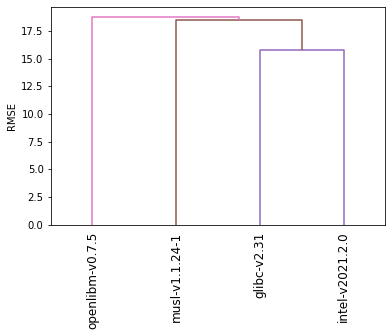

In [11]:
# Plot dendrogram
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

fig, ax = plt.subplots(1)
ax.set_ylabel("RMSE")
colors = list(mcolors.TABLEAU_COLORS)
hierarchy.dendrogram(Z, labels=lib_versions, leaf_rotation=90, link_color_func=lambda k: colors[k], ax=ax)
plt.show()

Differences appear to all be in the same range. It would be interesting to see if the proximity between glibc and intel appears with more subjects.

## Visualization

Are the differences localized spatially?

/home/glatard/code/imcomp/venv/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
<ipython-input-12-2ff225cddc32>:20: RuntimeWarning: invalid value encountered in true_divide
  rel_diff = nib.Nifti1Image((data1-data2)/(data1), im1.affine)
/home/glatard/code/imcomp/venv/lib/python3.8/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


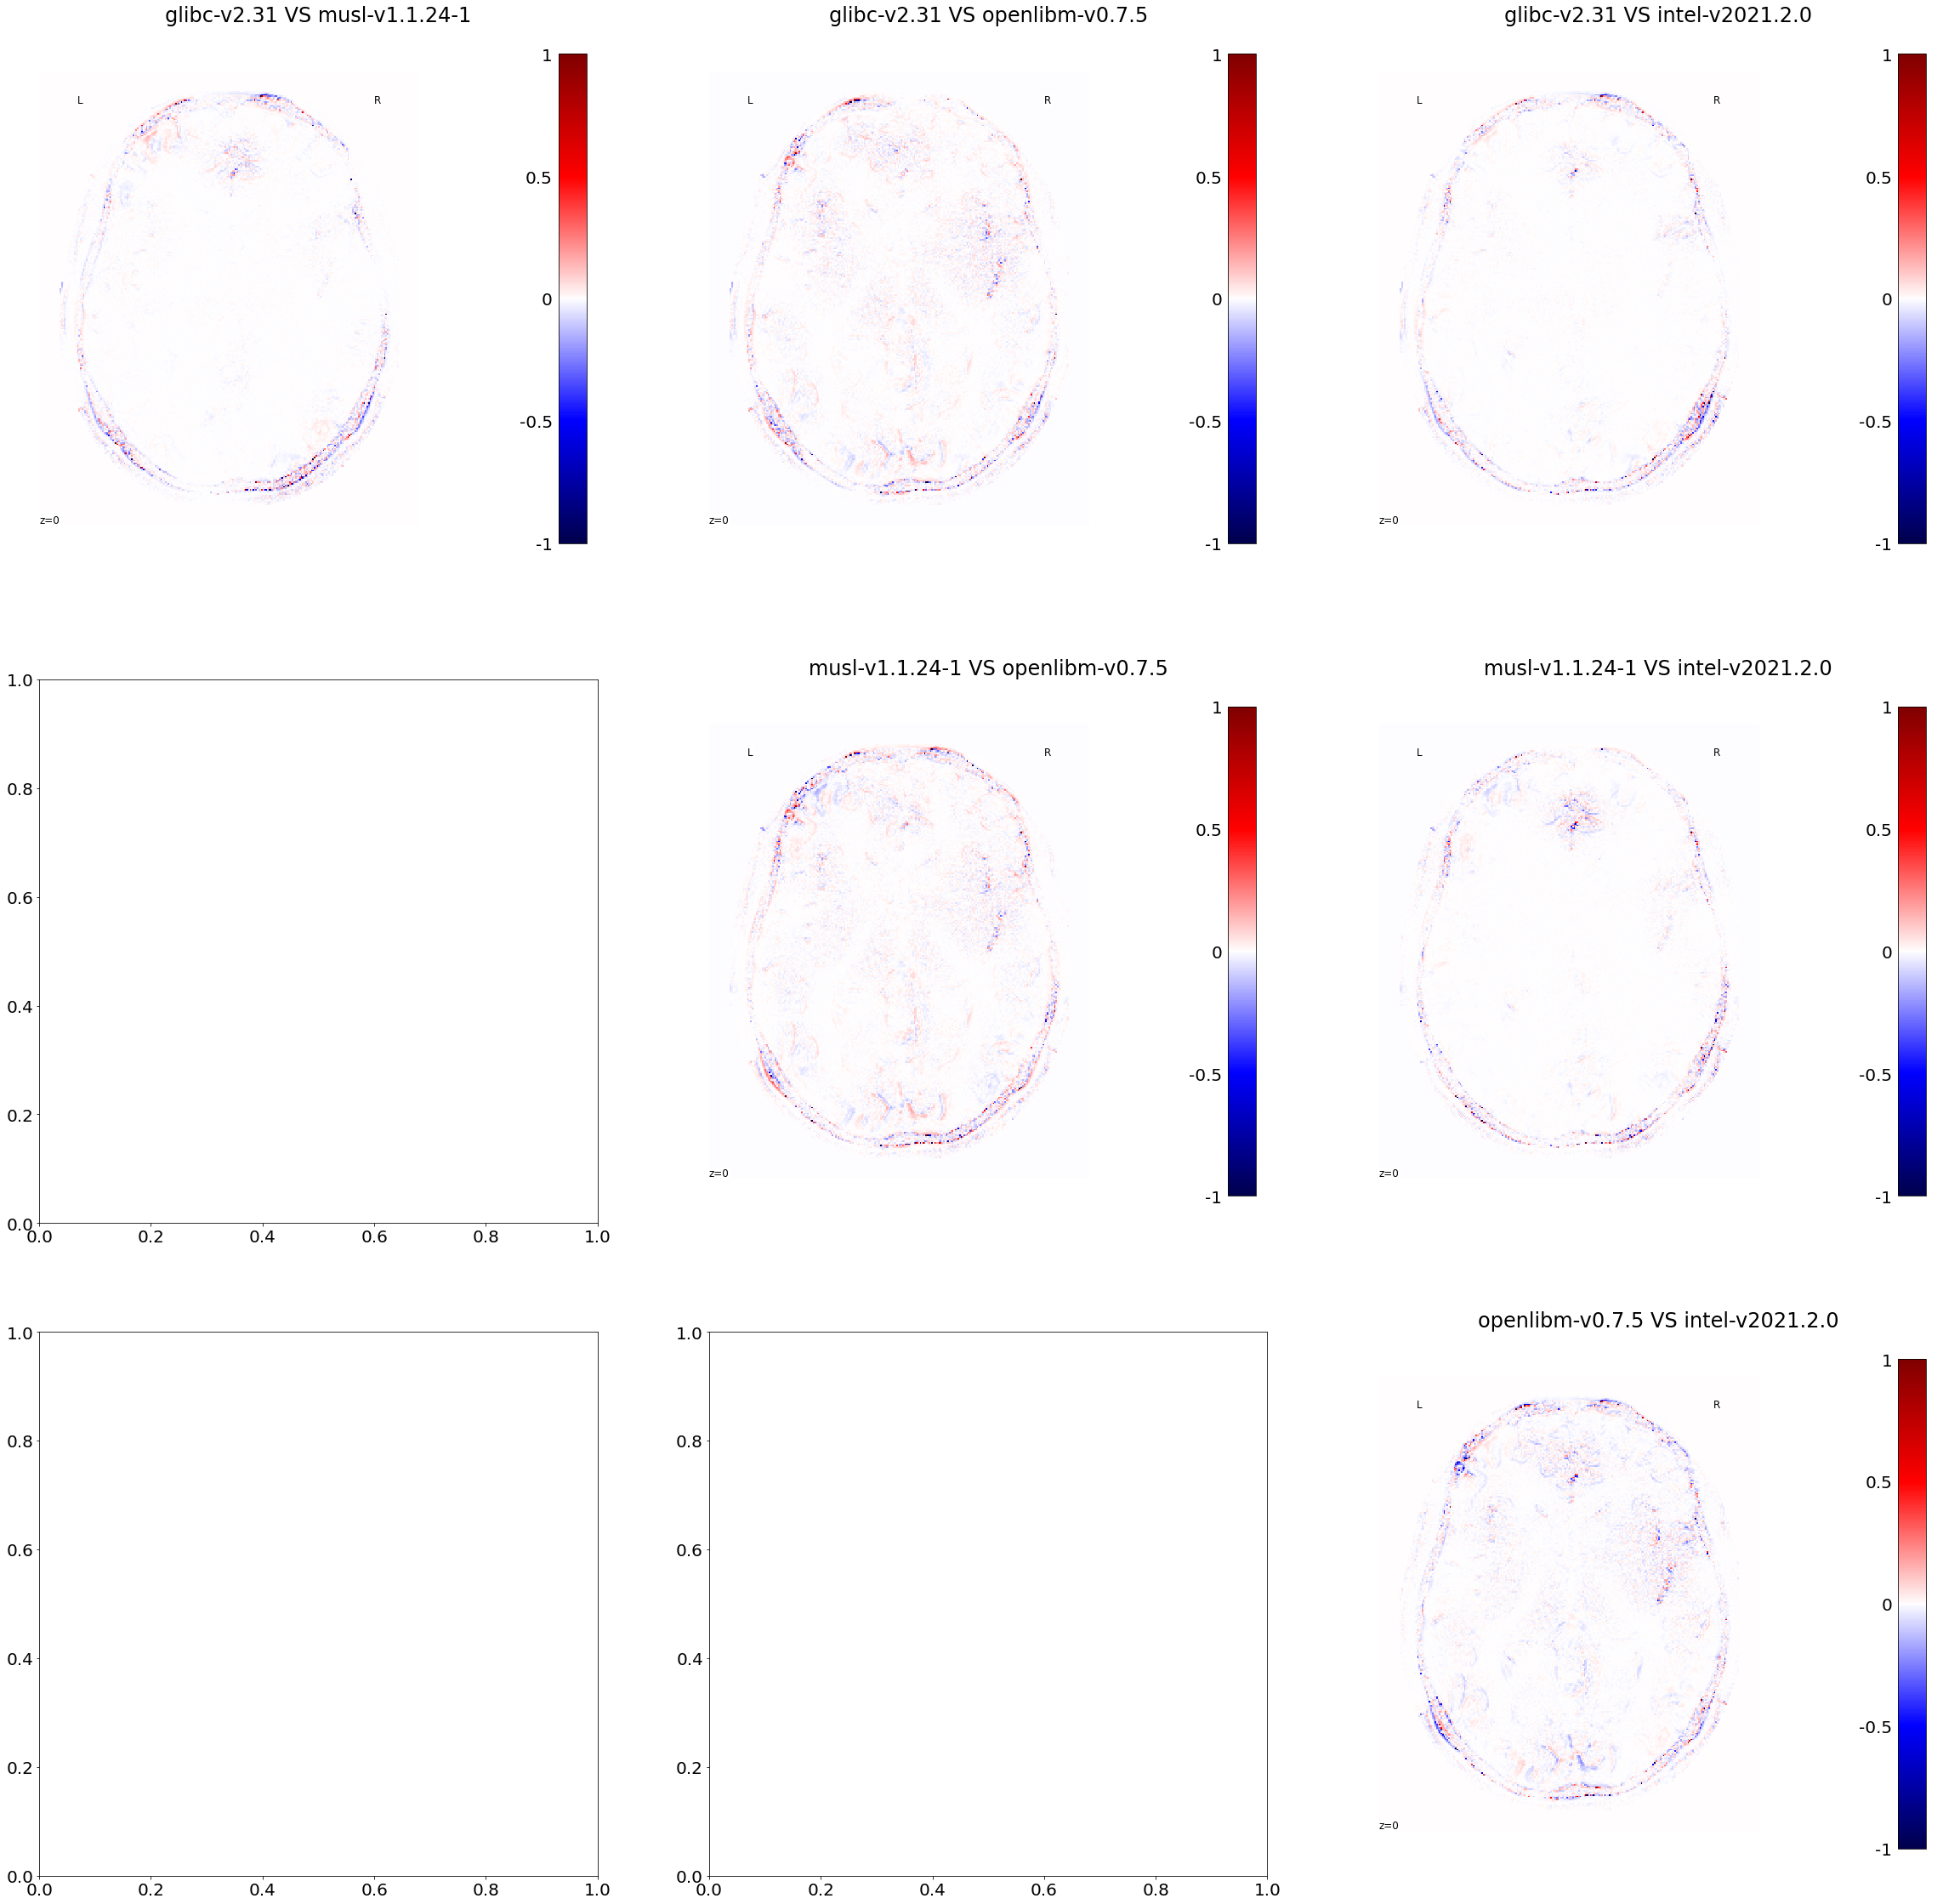

In [12]:
import matplotlib
import nilearn.plotting as nilp
import matplotlib.cm as cm
from matplotlib import pyplot as plt

matplotlib.rcParams.update({'font.size': 20})

T1_data = [nib.load(os.path.join(data_dir, lib_version, subject, 'MNINonLinear', 'T1w.nii.gz'))
                    for lib_version in lib_versions for subject in subjects ]


fig, axs = plt.subplots(len(T1_data)-1, len(T1_data)-1, figsize=(40,40))

for i in range(len(T1_data)-1):
    for j in range(i+1, len(T1_data)):
        im1 = T1_data[i]
        data1 = im1.get_fdata()*mask_img_dat
        im2 = T1_data[j]
        data2 = im2.get_fdata()*mask_img_dat
        rel_diff = nib.Nifti1Image((data1-data2)/(data1), im1.affine)
        axs[i, j-1].set_title(lib_versions[i]+" VS "+lib_versions[j])
        nilp.plot_img(rel_diff, cmap=cm.seismic, cut_coords=(0,), 
                      vmin=-1, vmax=1, colorbar=True, draw_cross=False, display_mode='z', axes=axs[i, j-1])

plt.show()

A spatial dependency of numerical differences is observed in the brain. For instance, openlibm differs from the other libraries in the occipital lobe, and intel is singular in the frontal lobe. While it would be surprising that the spatial localization of such differences be consisent across subjects, it suggests that numerical libraries might be converging to different local minima during non linear registration.

# Future work

## Next
* Measure numerical accuracy of the pipeline by comparing with [GNU MPFR](https://www.mpfr.org)
* Process more subjects

## Later
* Measure numerical precision of the pipeline for each library using MCA
* Measure imaging quality of the pipeline for each library by visual QC
* Measure "biological" performance of the pipeline for each library using age regression